In [7]:
!wget http://cicresearch.ca/CICDataset/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/MachineLearningCSV.zip

--2025-05-14 22:06:50--  http://cicresearch.ca/CICDataset/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/MachineLearningCSV.zip
Resolving cicresearch.ca (cicresearch.ca)... 205.174.165.80
Connecting to cicresearch.ca (cicresearch.ca)|205.174.165.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235102953 (224M) [application/zip]
Saving to: ‘MachineLearningCSV.zip’

MachineLearningCSV. 100%[===================>] 224.21M  7.75MB/s    in 31s     

2025-05-14 22:07:22 (7.17 MB/s) - ‘MachineLearningCSV.zip’ saved [235102953/235102953]



In [8]:
!unzip MachineLearningCSV.zip

Archive:  MachineLearningCSV.zip
   creating: MachineLearningCVE/
  inflating: MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load and merge all files
all_files = glob.glob("MachineLearningCVE/*.csv")
dfs = []
for file in all_files:
    df = pd.read_csv(file)
    df['Source_File'] = file.split('/')[-1]  # Track source file
    dfs.append(df)

merged_data = pd.concat(dfs, ignore_index=True)

In [4]:
# Drop constant features (as per paper)
constant_features = [' Fwd URG Flags', ' Bwd URG Flags', ' CWE Flag Count',
    'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
    ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
    ' Bwd PSH Flags']
print(merged_data.columns)
merged_data = merged_data.drop(columns=constant_features)

# Clean data
merged_data = merged_data.drop_duplicates()
merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [5]:
# --------------------------------------------------
# 1. Attack Grouping (Based on Paper's Methodology)
# --------------------------------------------------
attack_mapping = {
    # Benign
    'BENIGN': 'Benign',

    # Botnet ARES
    'Bot': 'Botnet ARES',

    # PortScan
    'PortScan': 'PortScan',

    # Brute Force Group
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Infiltration': 'Brute Force',  # Map infiltration to brute force

    # Dos/DDoS Group
    'DDoS': 'Dos/DDoS',
    'DoS slowloris': 'Dos/DDoS',
    'DoS Slowhttptest': 'Dos/DDoS',
    'DoS Hulk': 'Dos/DDoS',
    'DoS GoldenEye': 'Dos/DDoS',

    # Web Attack Group
    'Web Attack – Brute Force': 'Web Attack',
    'Web Attack – XSS': 'Web Attack',
    'Web Attack – Sql Injection': 'Web Attack',
    'Heartbleed': 'Web Attack'  # Map heartbleed to web attacks
}
# Apply attack grouping
merged_data[' Label'] = merged_data[' Label'].map(attack_mapping)

# Remove any remaining unmapped attacks
merged_data = merged_data.dropna(subset=[' Label'])

# --------------------------------------------------
# 2. Label Encoding (Maintain Paper's Class Order)
# --------------------------------------------------
class_order = ['Benign', 'Botnet ARES', 'Brute Force',
              'Dos/DDoS', 'PortScan', 'Web Attack']

le = LabelEncoder()
le.fit(class_order)
merged_data[' Label'] = le.transform(merged_data[' Label'])

In [6]:
print(merged_data.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count',
       ' SYN Flag Count', ' RST Flag Count',

In [7]:
# --------------------------------------------------
# 3. Data Splitting (Stratified 80-20 Split)
# --------------------------------------------------
X = merged_data.drop(columns=[' Label', 'Source_File'])  # Features
y = merged_data[' Label']  # Encoded labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [8]:
# --------------------------------------------------
# 4. Resampling Pipeline (Paper's Approach)
# --------------------------------------------------
# Define sampling strategy based on paper's Table 2
sampling_strategy = {
    0: 1_628_430,  # Benign (undersample)
    1: 1_577,       # Botnet ARES (oversample)
    2: 7_000,       # Brute Force (oversample)
    3: 250_000,     # Dos/DDoS
    4: 45_000,      # PortScan
    5: 1_754        # Web Attack (oversample)
}

resampler = Pipeline([
    ('under', RandomUnderSampler(
        sampling_strategy={4: sampling_strategy[4]},
        random_state=42
    )),
    ('over', SMOTE(
        sampling_strategy={
            1: sampling_strategy[1],
            5: sampling_strategy[5]
        },
        k_neighbors=5,
        random_state=42
    ))
])

# Apply resampling
X_res, y_res = resampler.fit_resample(X_train, y_train)

In [9]:
# --------------------------------------------------
# 5. Verify Class Distribution
# --------------------------------------------------
resampled_counts = pd.Series(y_res).value_counts().sort_index()
print("\nFinal Class Distribution:")
print(f"Benign (0): {resampled_counts[0]:,}")
print(f"Botnet ARES (1): {resampled_counts[1]:,}")
print(f"Brute Force (2): {resampled_counts[2]:,}")
print(f"Dos/DDoS (3): {resampled_counts[3]:,}")
print(f"PortScan (4): {resampled_counts[4]:,}")
print(f"Web Attack (5): {resampled_counts[5]:,}")


Final Class Distribution:
Benign (0): 1,717,519
Botnet ARES (1): 1,577
Brute Force (2): 7,349
Dos/DDoS (3): 257,407
PortScan (4): 45,000
Web Attack (5): 1,754


In [10]:
# Standardize features
scaler = StandardScaler()
X_res = scaler.fit_transform(X_res)
X_test = scaler.transform(X_test)

# --------------------------
# 3. Convert to PyTorch Tensors
# --------------------------
train_dataset = TensorDataset(
    torch.FloatTensor(X_res).to(device),
    torch.LongTensor(y_res.to_numpy()).to(device)
)

test_dataset = TensorDataset(
    torch.FloatTensor(X_test).to(device),
    torch.LongTensor(y_test.to_numpy()).to(device)
)

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
class IDS_DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(IDS_DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.layers(x)


model = IDS_DNN(input_size=X_res.shape[1], num_classes=len(le.classes_)).to(device)

In [12]:
# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0):
        super().__init__()
        self.weight = weight
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        return torch.mean((1 - pt) ** self.gamma * ce_loss)

Epoch 1/15
Train Loss: 0.1748 | Acc: 93.30%
Test Loss: 0.0660 | Acc: 95.28%
-------------------------
Epoch 2/15
Train Loss: 0.0655 | Acc: 95.55%
Test Loss: 0.0629 | Acc: 94.40%
-------------------------
No improvement for 1/5 epochs
Epoch 3/15
Train Loss: 0.0541 | Acc: 96.03%
Test Loss: 0.0631 | Acc: 97.63%
-------------------------
Epoch 4/15
Train Loss: 0.0554 | Acc: 96.18%
Test Loss: 0.0514 | Acc: 96.80%
-------------------------
No improvement for 1/5 epochs
Epoch 5/15
Train Loss: 0.0488 | Acc: 96.34%
Test Loss: 0.0515 | Acc: 96.31%
-------------------------
Epoch 6/15
Train Loss: 0.0454 | Acc: 96.62%
Test Loss: 0.0469 | Acc: 97.28%
-------------------------
No improvement for 1/5 epochs
Epoch 7/15
Train Loss: 0.0462 | Acc: 96.69%
Test Loss: 0.1112 | Acc: 94.72%
-------------------------
No improvement for 2/5 epochs
Epoch 8/15
Train Loss: 0.0459 | Acc: 96.62%
Test Loss: 0.0479 | Acc: 96.96%
-------------------------
No improvement for 3/5 epochs
Epoch 9/15
Train Loss: 0.0436 | Ac

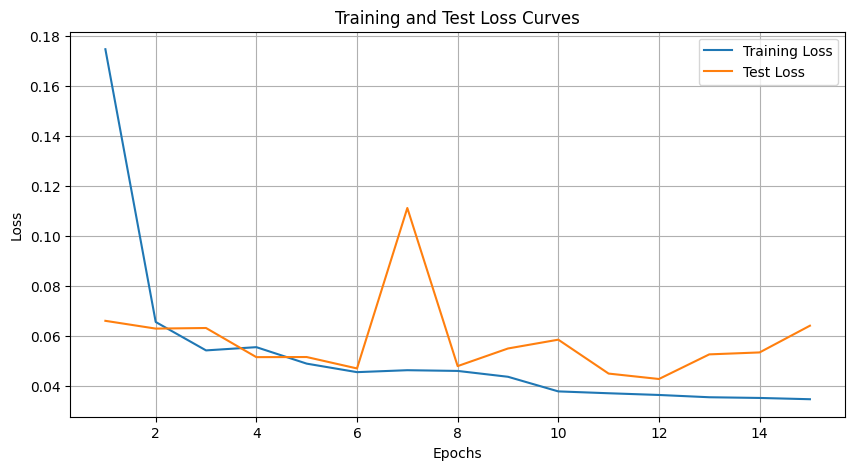

In [13]:
# --------------------------
# 5. Training Setup
# --------------------------
class_weights = torch.tensor([
    1.0,   # Benign (0)        → 1.6M samples (low weight)
    150.0,  # Botnet ARES (1)  → 1.5k samples (high weight)
    5.0,   # Brute Force (2)  → 6.8k samples
    1.5,   # Dos/DDoS (3)     → 256k samples
    3.0,   # PortScan (4)     → 45k samples
    200.0  # Web Attack (5)   → 1.5k samples (highest weight)
]).to(device)

criterion = FocalLoss(weight=class_weights, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

# --------------------------
# 6. Training Loop
# --------------------------
# Modify your training loop to track losses
train_losses = []
test_losses = []
num_epochs = 30
best_test_loss = float('inf')
patience = 5  # Stop after 5 epochs without improvement
counter = 0

num_epochs = 15  # Keep your original epoch count

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    correct = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Testing phase
    model.eval()
    epoch_test_loss = 0
    test_correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

    # Calculate average test loss for the epoch
    avg_test_loss = epoch_test_loss / len(test_loader)
    scheduler.step(avg_test_loss)  # Update learning rate
    test_losses.append(avg_test_loss)

    # --- Early Stopping Check ---
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        counter = 0  # Reset counter if test loss improves
        # Optional: Save best model weights
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        print(f"No improvement for {counter}/{patience} epochs")

    # --- Early Stopping Trigger ---
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Print statistics
    train_acc = 100 * correct / len(train_dataset)
    test_acc = 100 * test_correct / len(test_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f} | Acc: {test_acc:.2f}%")
    print("-------------------------")

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, len(train_losses)+1),  # Dynamic x-axis
    train_losses,
    label='Training Loss'
)
plt.plot(
    range(1, len(test_losses)+1),  # Dynamic x-axis
    test_losses,
    label='Test Loss'
)
plt.title('Training and Test Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# --------------------------
# 7. Evaluation
# --------------------------
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.97      0.99    429380
 Botnet ARES       0.08      1.00      0.14       390
 Brute Force       0.89      0.99      0.94      1837
    Dos/DDoS       1.00      0.99      0.99     64352
    PortScan       0.75      1.00      0.85     18139
  Web Attack       1.00      0.50      0.67         2

    accuracy                           0.98    514100
   macro avg       0.78      0.91      0.76    514100
weighted avg       0.99      0.98      0.98    514100

